# Import Important Libraries

In [8]:
# Importing Libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import mlflow
#import local libraries
#Adding scripts path
# sys.path.append(os.path.abspath(os.path.join('..')))
# from scripts.data_loader import load_df_from_csv, optimize_df
# from scripts.ML_modelling_utils import *
# from scripts.data_information import DataInfo
# from scripts.data_manipulation import DataManipulator

In [6]:
# pd.set_option('max_column', None)
pd.set_option('display.float_format', '{:.2f}'.format)
%matplotlib inline

In [7]:
train_data = pd.read_csv('../data/train.csv')
train_data = train_data[['Date','Sales']]
train_data = train_data.groupby('Date').agg({'Sales':'mean'})

C:\Users\User\AppData\Local\Temp\ipykernel_15920\1334194538.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('../data/train.csv')


In [11]:
def scale_column(df, column: str, range_tup: tuple = (0, 1)) -> pd.DataFrame:
        """
            Returns the objects DataFrames column normalized using Normalizer
            Parameters
            ----------
            column:
                Type: str
            length:
                Type: int
            Returns
            -------
            pd.DataFrame
        """
        try:
            std_column_df = pd.DataFrame(df[column])
            std_column_values = std_column_df.values
            minmax_scaler = MinMaxScaler(feature_range=range_tup)
            normalized_data = minmax_scaler.fit_transform(std_column_values)
            df[column] = normalized_data

            return df
        except:
            print("Failed to standardize the column")
def scale_columns(df, columns: list, range_tup: tuple = (0, 1)) -> pd.DataFrame:
        try:
            for col in columns:
                df = scale_column(train_data,col, range_tup)

            return df
        except:
            print(f"Failed to MinMax standardize {col} column")
# manipulator = DataManipulator(train_data, deep=True)

In [14]:
the_df = scale_columns(train_data,['Sales'], range_tup=(-1,1))

In [15]:
def optimize_df(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
       A simple function which optimizes the data types of the dataframe and returns it
        Parameters
        ----------
        dataframe:
            Type: pd.DataFrame
        Returns
        -------
        pd.DataFrame
    """
    data_types = dataframe.dtypes
    optimizable = ['float64', 'int64']
    for col in data_types.index:
        if(data_types[col] in optimizable):
            if(data_types[col] == 'float64'):
                # downcasting a float column
                dataframe[col] = pd.to_numeric(
                    dataframe[col], downcast='float')
            elif(data_types[col] == 'int64'):
                # downcasting an integer column
                dataframe[col] = pd.to_numeric(
                    dataframe[col], downcast='unsigned')

    return dataframe
scaled_data = optimize_df(the_df)

In [16]:
data = train_data

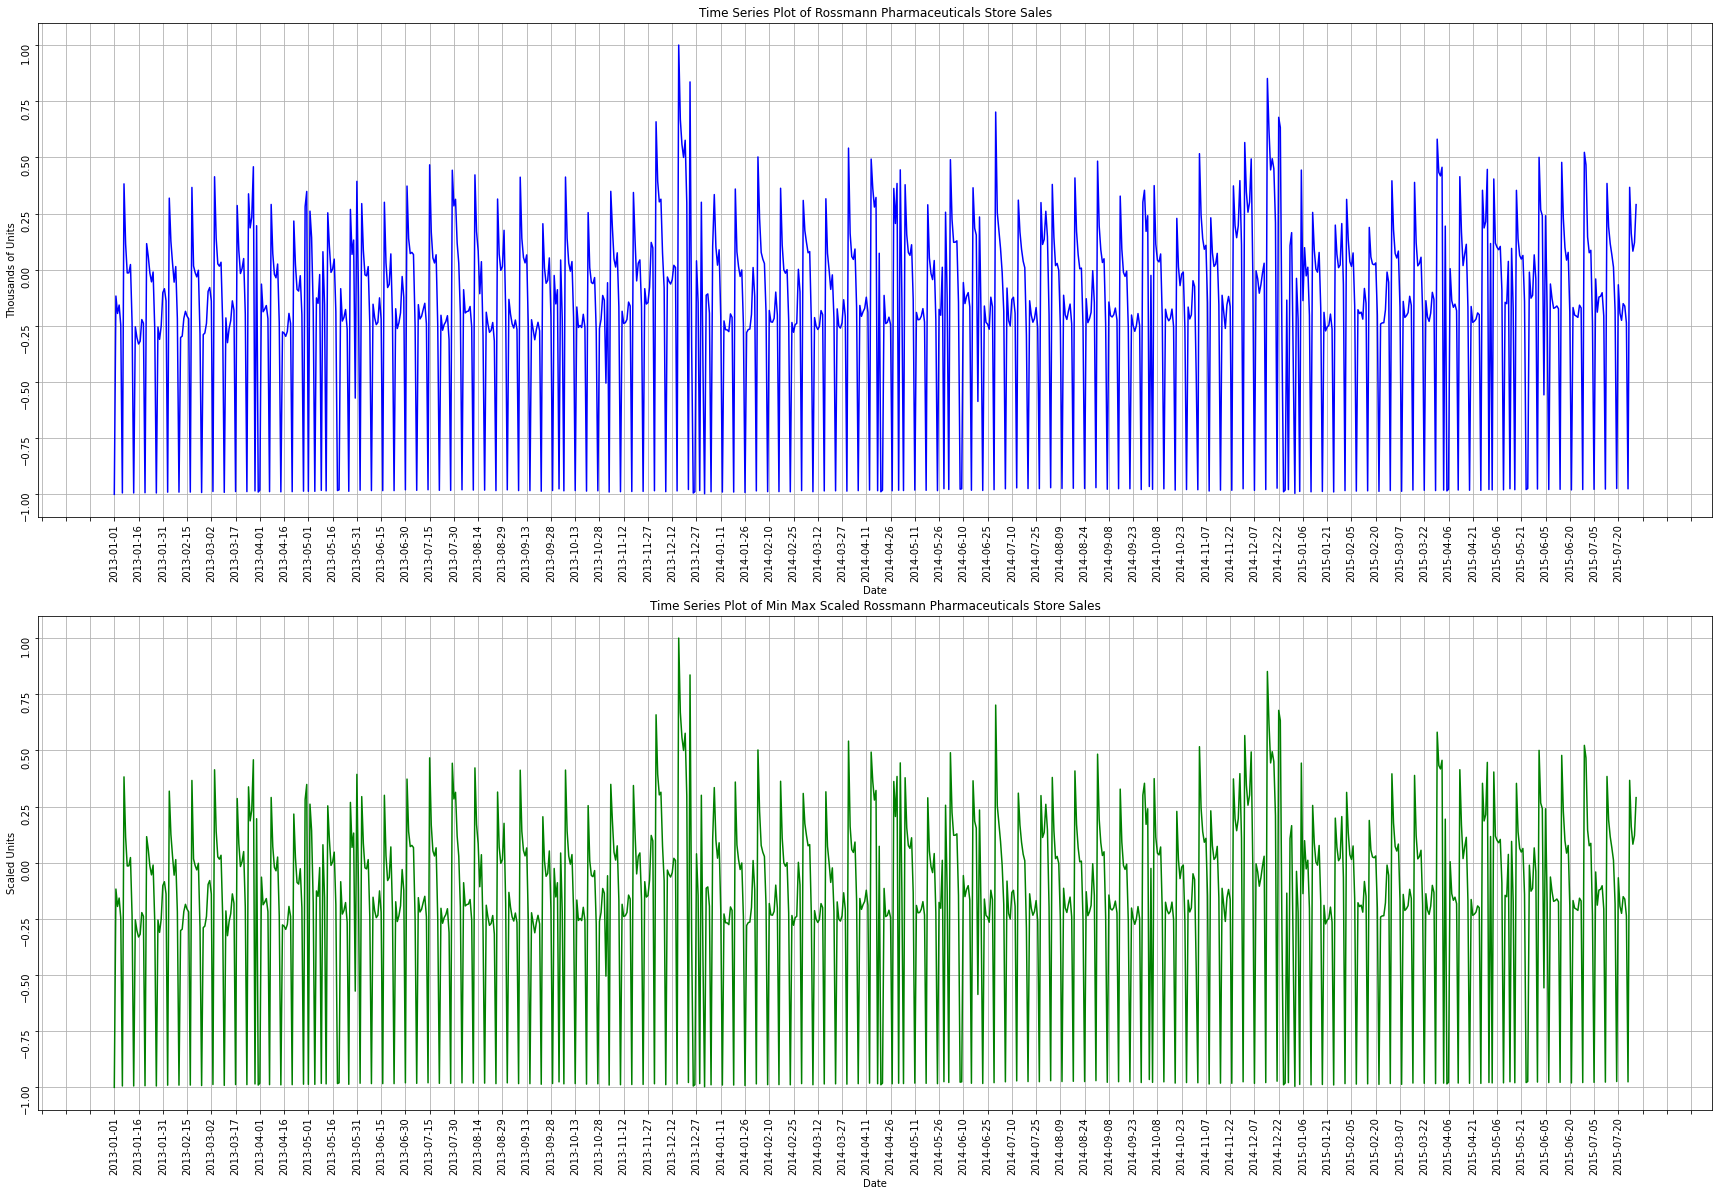

In [17]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(data.index, data.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(scaled_data.index, scaled_data.Sales, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text(
    'Time Series Plot of Scaled Sales')
ax2.grid(True)
plt.savefig('../images/timeseriesandtimescaled.png')
plt.show()


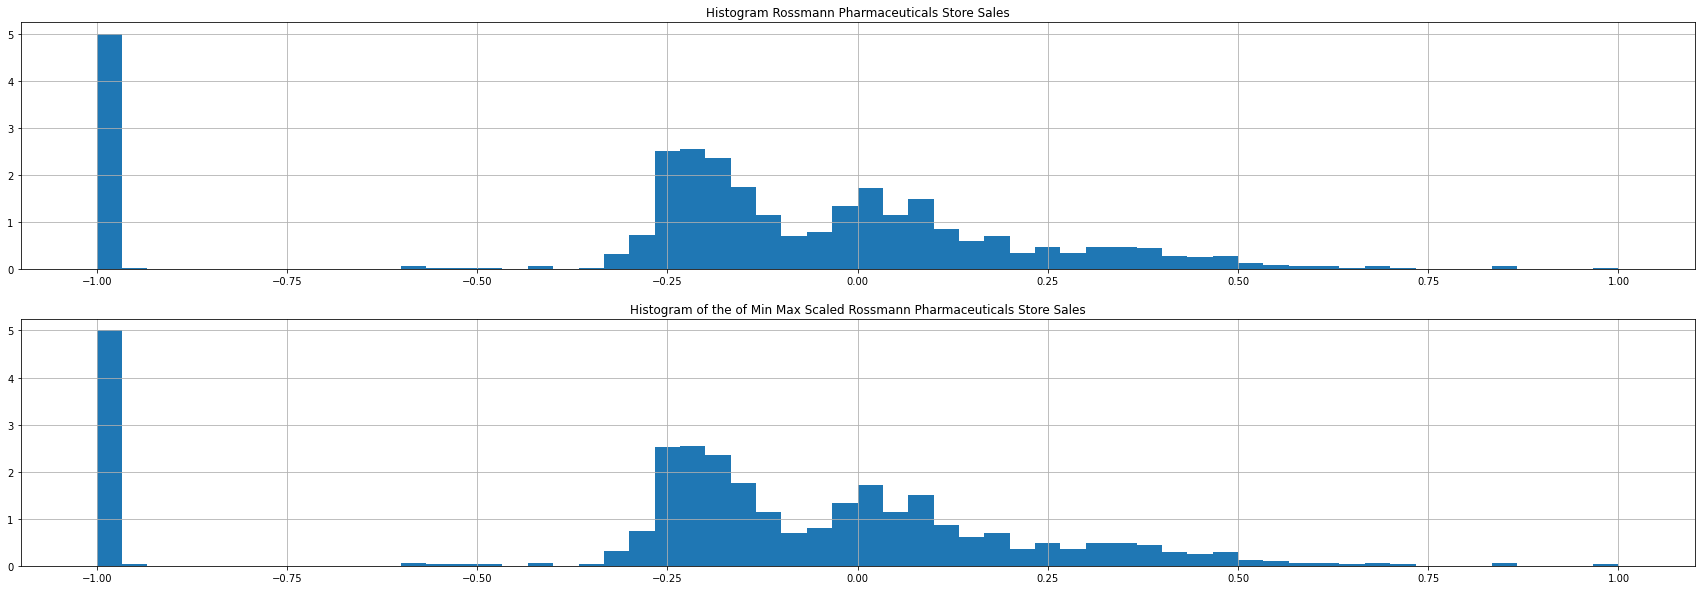

In [18]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(data.Sales, density=True, bins=60)
ax1.title.set_text('Histogram of Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(scaled_data.Sales, density=True, bins=60)
ax2.title.set_text('Histogram of the of Scaled  Sales')
ax2.grid(True)
plt.savefig('../images/histogramofsales.png')
plt.show()

In [19]:
scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   942 non-null    float32
dtypes: float32(1)
memory usage: 11.0+ KB


In [20]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [21]:
sales_difference = difference(scaled_data.Sales.values)

In [22]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(
        f"{prefix}  Autocorrelations of Scaled Sales")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.savefig(f'../images/{prefix}autocorrelation.png')
    plt.show()

In [23]:
acfSalesScaled = acf(scaled_data.Sales.values, fft=True, nlags=45)
acfSalesScaledNp = np.array(acfSalesScaled)

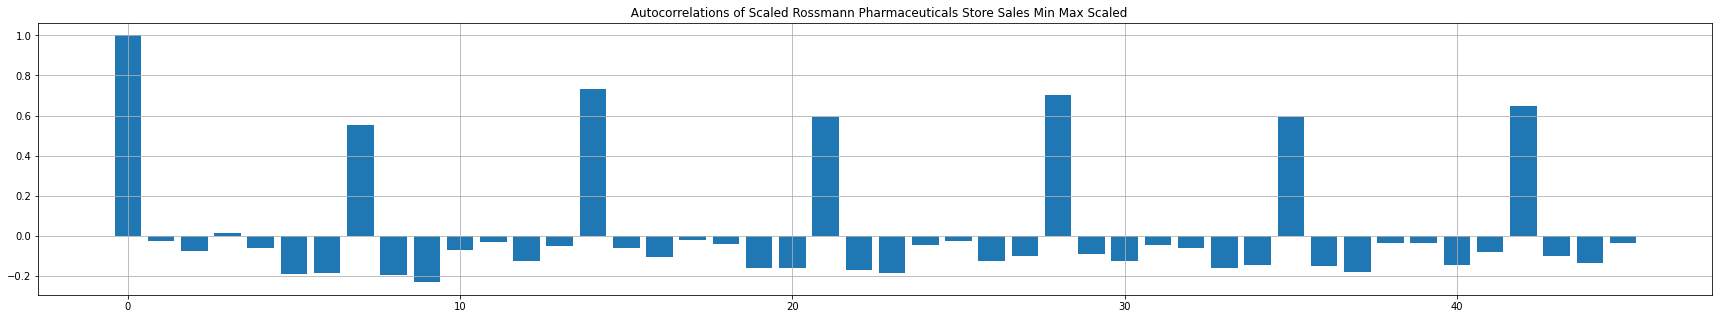

In [24]:
corrPlots(acfSalesScaledNp, '')

In [25]:
pacfSalesScaled = pacf(scaled_data.Sales.values, nlags=45)
pacfSalesScaledNp = np.array(pacfSalesScaled)

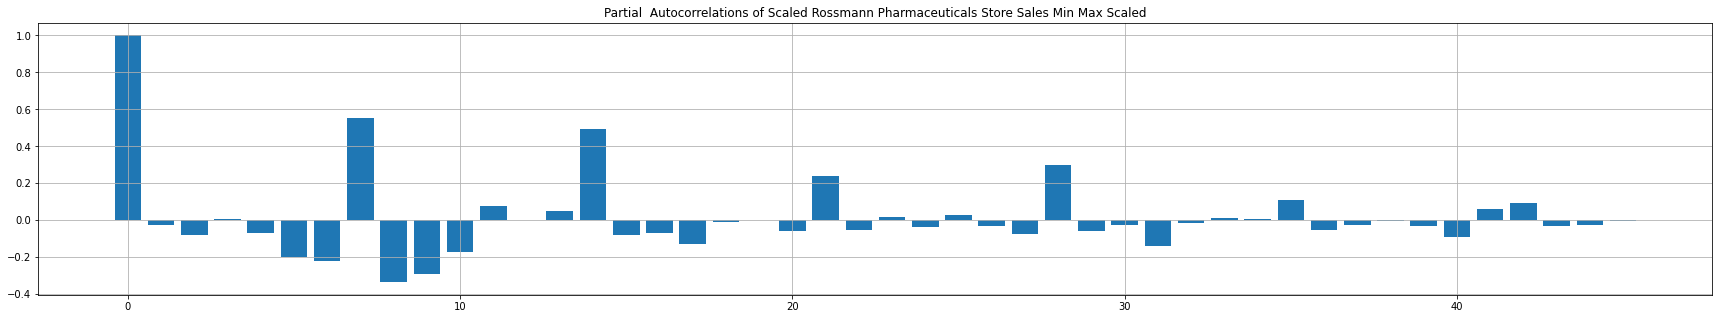

In [26]:
corrPlots(pacfSalesScaledNp, "Partial")

In [28]:
# Set window of past points for LSTM Model
# 6 Weeks is 45 Days (We have daily data of stores)
SIZE = len(scaled_data.Sales)
WINDOW_SIZE = 45
BATCH_SIZE = SIZE-WINDOW_SIZE*2
EPOCHS = 10

In [29]:
# Spliting Data to Train and Test (80/20)
DateTrain = scaled_data.index.values[0:BATCH_SIZE]
DateValid = scaled_data.index.values[BATCH_SIZE:]
XTrain = scaled_data.Sales.values[0:BATCH_SIZE].astype('float32')
XValid = scaled_data.Sales.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (852, 1)
Shape of the validation set date series:  (90, 1)

Shape of the training set logarithm of sales series:  (852,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (90,)


In [30]:
tf.random.set_seed(0)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([852, 1])

In [31]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

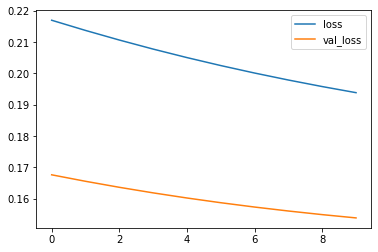

In [32]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.batch(BATCH_SIZE).prefetch(1)
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="mse", optimizer='adam')
history = model.fit(DatasetTrain, epochs=EPOCHS,
                    validation_data=DatasetVal, verbose=0)
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [46]:
# Set window of past points for LSTM model
window = 45

# # Split 80/20 into train/test data
last = int(len(scaled_data.Sales)/5.0)
Xtrain = scaled_data.Sales[:-last]
Xtest = scaled_data.Sales[-last-window:]

# # Store window number of points as a sequence
xin = []
next_X = []
for i in range(window, len(Xtrain)):
    try:
        xin.append(Xtrain[i-window:i])
        next_X.append(Xtrain[i])
    except Exception as e:
        print(f'i value : {i}')
        exit(0)

# Reshape data to format for LSTM
xin, next_X = np.array(xin), np.array(next_X)
xin = xin.reshape(xin.shape[0], xin.shape[1], 1)

In [47]:
# Initialize LSTM model
m = Sequential()
m.add(LSTM(units=50, return_sequences=True, input_shape=(xin.shape[1], 1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.2))
m.add(Dense(units=1))
m.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [48]:
# Fit LSTM model
history = m.fit(xin, next_X, epochs=700, batch_size=50, verbose=0)

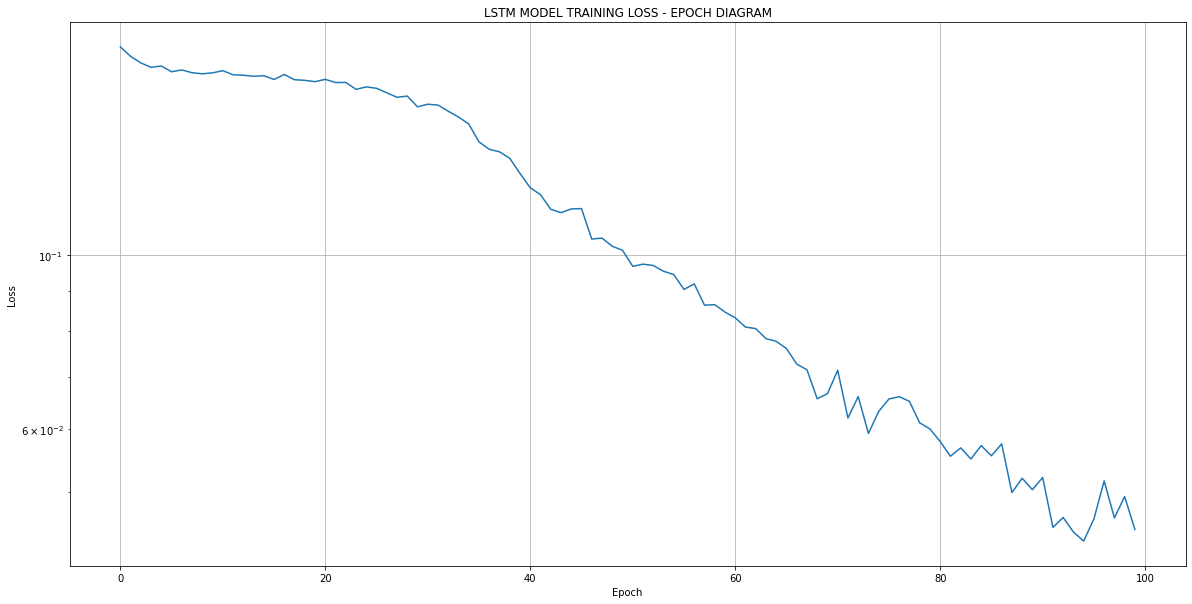

In [49]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.title('LSTM MODEL TRAINING LOSS - EPOCH DIAGRAM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.semilogy(history.history['loss'])

In [50]:
# Last Loss Value
history.history['loss'][-1]

0.044740352779626846

6/6 [==============================] - 2s 17ms/step


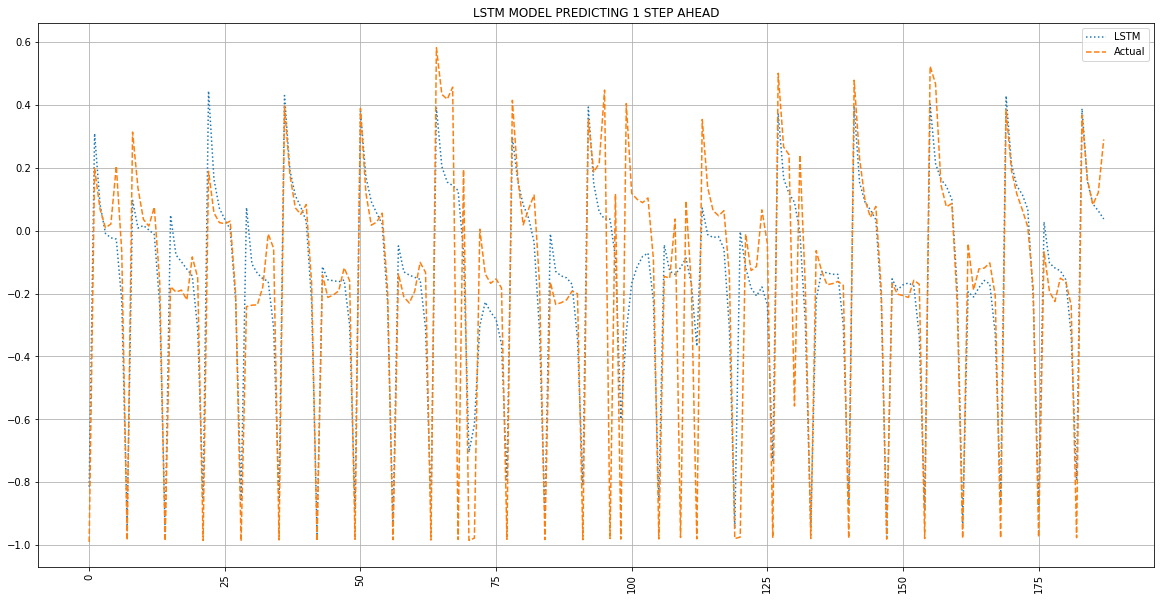

In [51]:
# Store "window" points as a sequence
xin = []
next_X1 = []
for i in range(window, len(Xtest)):
    xin.append(Xtest[i-window:i])
    next_X1.append(Xtest[i])

# Reshape data to format for LSTM
xin, next_X1 = np.array(xin), np.array(next_X1)
xin = xin.reshape((xin.shape[0], xin.shape[1], 1))

# Predict the next value (1 step ahead)
X_pred = m.predict(xin)

# Plot prediction vs actual for test data
plt.figure(figsize=(20, 10))
plt.title('LSTM MODEL PREDICTING 1 STEP AHEAD')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred, ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()

1/1 [==============================] - 0s 38ms/step


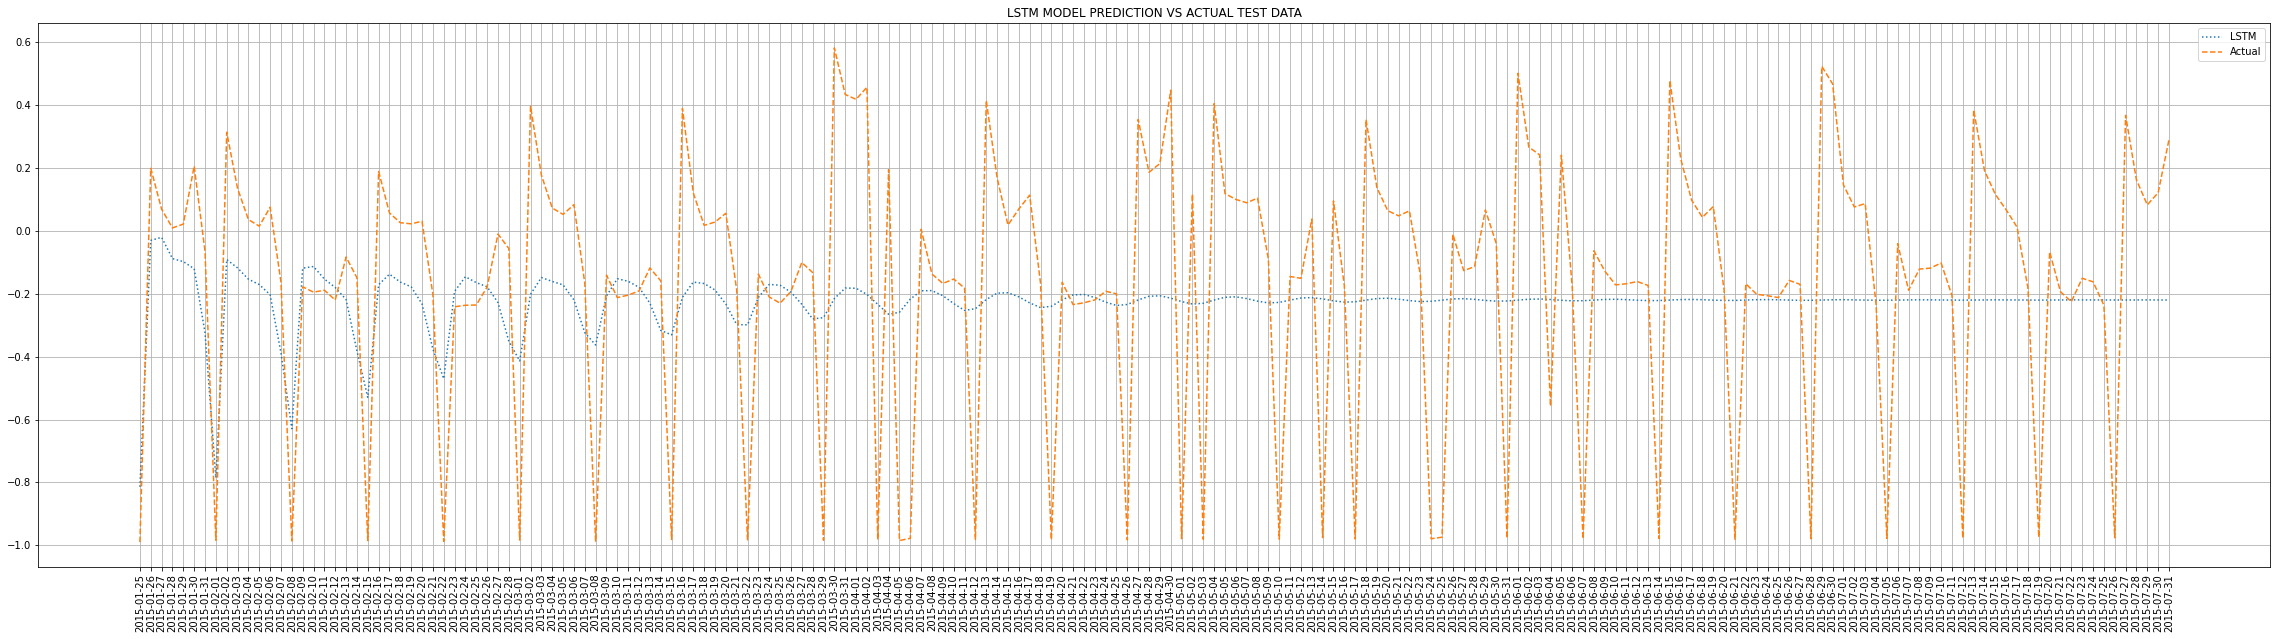

In [52]:
# Using predicted values to predict next step
X_pred = Xtest.copy()
for i in range(window, len(X_pred)):
    xin = X_pred[i-window:i].to_numpy().reshape((1, window, 1))
    X_pred[i] = m.predict(xin)

# Plot prediction vs actual for test data
plt.figure(figsize=(40,10))
plt.title('LSTM MODEL PREDICTION VS ACTUAL TEST DATA')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred[window:], ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()

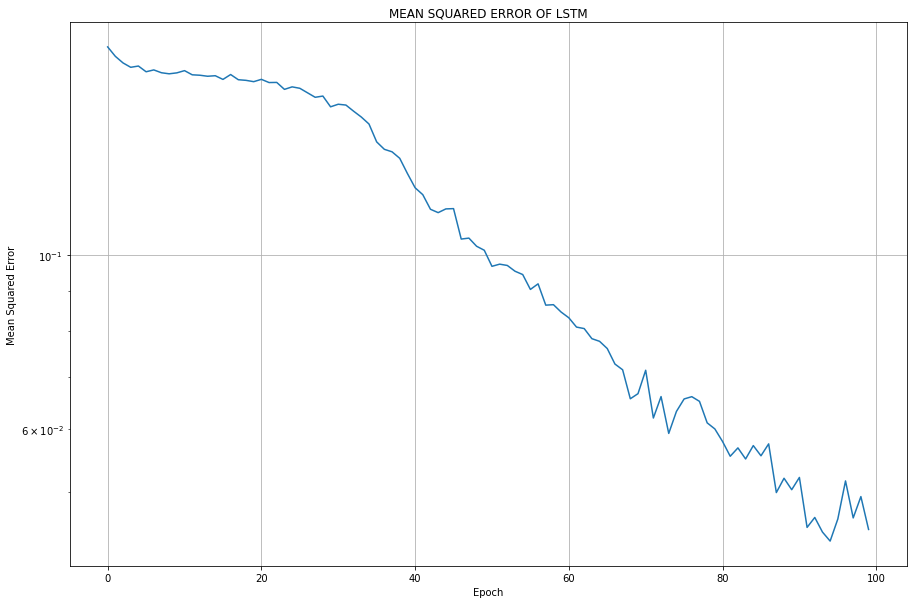

In [53]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.title('MEAN SQUARED ERROR OF LSTM')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.semilogy(history.history['mse'])

In [54]:
# Last MSE Value
history.history['mse'][-1]

0.044740352779626846

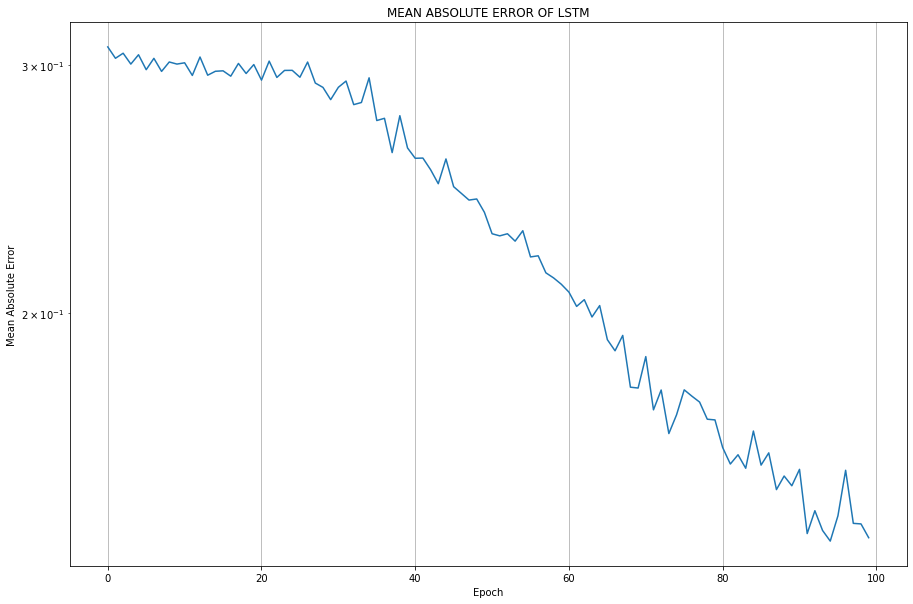

In [55]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.title('MEAN ABSOLUTE ERROR OF LSTM')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.semilogy(history.history['mae'])

In [56]:
# Last MAE Value
history.history['mae'][-1]

0.13843362033367157